# Predicting Outage Severity in terms of Duration

**Name(s)**: (Natasha Lie)

**Website Link**: (https://natashalie8.github.io/Energy-Outage-Trends-EDA-and-Predictive-Modeling/)

In [116]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

# datavis tools
import plotly.express as px
pd.options.plotting.backend = 'plotly'
import seaborn as sns
import matplotlib.pyplot as plt
import folium

import scipy.stats
import warnings
warnings.filterwarnings("ignore")

## Step 1: Introduction

As households become increasingly reliant on electrical devices, power outages carry greater costs for the individuals affected. People want to know how long an outage will last so they can plan ahead and return to their normal routines as quickly as possible.

In my analysis, I investigated the question: **Which factors contribute the most to the severity of the power outage in terms of outage duration?**

## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning
First some preliminary cleaning: we'll replace all the values that should be missing with `NaN`. Then, we'll convert all numerical values to floats to have consistency across my dataframe. Finally, we'll make sure all the values make sense, and correct them if not.

In [117]:
pathway = Path('outage2.csv')
df = pd.read_csv(pathway)
df.columns
df = df.drop(['variables', 'OBS'], axis=1).drop([0])
df

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",5:00:00 PM,"Sunday, July 3, 2011",8:00:00 PM,severe weather,NaN,NaN,3060,NaN,70000.0,11.6,9.18,6.81,9.28,2332915,2114774,2113291,6562520,35.54907261,32.22502941,32.20243138,2308736.0,276286.0,10673.0,2595696.0,88.9448,10.6440,0.4112,51268,47586,1.077375699,1.6,4802,274182,1.751391412,2.2,5348119.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
2,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",6:38:00 PM,"Sunday, May 11, 2014",6:39:00 PM,intentional attack,vandalism,NaN,1,NaN,NaN,12.12,9.71,6.49,9.28,1586986,1807756,1887927,5284231,30.03248722,34.21038936,35.72756376,2345860.0,284978.0,9898.0,2640737.0,88.8335,10.7916,0.3748,53499,49091,1.089792426,1.9,5226,291955,1.790001884,2.2,5457125.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
3,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",8:00:00 PM,"Thursday, October 28, 2010",10:00:00 PM,severe weather,heavy wind,NaN,3000,NaN,70000.0,10.87,8.19,6.07,8.15,1467293,1801683,1951295,5222116,28.09767152,34.50101453,37.36598344,2300291.0,276463.0,10150.0,2586905.0,88.9206,10.6870,0.3924,50447,47287,1.066825978,2.7,4571,267895,1.706265514,2.1,5310903.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
4,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Tuesday, June 19, 2012",4:30:00 AM,"Wednesday, June 20, 2012",11:00:00 PM,severe weather,thunderstorm,NaN,2550,NaN,68200.0,11.79,9.25,6.71,9.19,1851519,1941174,1993026,5787064,31.99409925,33.54333043,34.43932882,2317336.0,278466.0,11010.0,2606813.0,88.8954,10.6822,0.4224,51598,48156,1.071476036,0.6,5364,277627,1.932088738,2.2,5380443.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
5,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,"Saturday, July 18, 2015",2:00:00 AM,"Sunday, July 19, 2015",7:00:00 AM,severe weather,NaN,NaN,1740,250,250000.0,13.07,10.16,7.74,10.43,2028875,2161612,1777937,5970339,33.9825762,36.20585029,29.77949828,2374674.0,289044.0,9812.0,2673531.0,88.8216,10.8113,0.3670,54431,49844,1.092027125,1.7,4873,292023,1.668704177,2.2,5489594.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,"Tuesday, December 6, 2011",8:00:00 AM,"Tuesday, December 6, 2011",8:00:00 PM,public appeal,NaN,NaN,720,155,34500.0,8.41,7.8,6.2,7.56,488853,438133,386693,1313678,37.21254371,33.35162802,29.43590438,330738.0,60017.0,3639.0,394394.0,83.8598,15.2175,0.9227,57012,47586,1.19808347,9.8,934,39067,2.390764584,0.5,685326.0,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.59964921,2.401765255,2.401765255
1531,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaN,NaN,NaN,NaN,fuel supply emergency,Coal,NaN,NaN,1650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309997.0,53709.0,2331.0,366037.0,84.6901,14.6731,0.6368,42913,48909,0.877404977

The column names currently have periods and underscores instead of spaces. Let's replace these with spaces just to make things look a little prettier.

In [118]:
columns = list(df.columns)
df.columns = [re.sub(r'[._]+', ' ', col) for col in columns] # Split column names by '.' and '_'
for col in df.columns:
    # Try to convert the column to float
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        # If conversion fails, keep the column as string
        pass

In [119]:
df.head()

,YEAR,MONTH,U S STATE,POSTAL CODE,NERC REGION,CLIMATE REGION,ANOMALY LEVEL,CLIMATE CATEGORY,OUTAGE START DATE,OUTAGE START TIME,OUTAGE RESTORATION DATE,OUTAGE RESTORATION TIME,CAUSE CATEGORY,CAUSE CATEGORY DETAIL,HURRICANE NAMES,OUTAGE DURATION,DEMAND LOSS MW,CUSTOMERS AFFECTED,RES PRICE,COM PRICE,IND PRICE,TOTAL PRICE,RES SALES,COM SALES,IND SALES,TOTAL SALES,RES PERCEN,COM PERCEN,IND PERCEN,RES CUSTOMERS,COM CUSTOMERS,IND CUSTOMERS,TOTAL CUSTOMERS,RES CUST PCT,COM CUST PCT,IND CUST PCT,PC REALGSP STATE,PC REALGSP USA,PC REALGSP REL,PC REALGSP CHANGE,UTIL REALGSP,TOTAL REALGSP,UTIL CONTRI,PI UTIL OFUSA,POPULATION,POPPCT URBAN,POPPCT UC,POPDEN URBAN,POPDEN UC,POPDEN RURAL,AREAPCT URBAN,AREAPCT UC,PCT LAND,PCT WATER TOT,PCT WATER INLAND
1,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",5:00:00 PM,"Sunday, July 3, 2011",8:00:00 PM,severe weather,NaN,NaN,3060.0,NaN,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736.0,276286.0,10673.0,2595696.0,88.9448,10.6440,0.4112,51268.0,47586.0,1.077376,1.6,4802.0,274182.0,1.751391,2.2,5348119.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",6:38:00 PM,"Sunday, May 11, 2014",6:39:00 PM,intentional attack,vandalism,NaN,1.0,NaN,NaN,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860.0,284978.0,9898.0,2640737.0,88.8335,10.7916,0.3748,53499.0,49091.0,1.089792,1.9,5226.0,291955.0,1.790002,2.2,5457125.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",8:00:00 PM,"Thursday, October 28, 2010",10:00:00 PM,severe weather,heavy wind,NaN,3000.0,NaN,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291.0,276463.0,10150.0,2586905.0,88.9206,10.6870,0.3924,50447.0,47287.0,1.066826,2.7,4571.0,267895.0,1.706266,2.1,5310903.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Tuesday, June 19, 2012",4:30:00 AM,"Wednesday, June 20, 2012",11:00:00 PM,severe weather,thunderstorm,NaN,2550.0,NaN,68200.0,11.79,9.25,6.71,9.19,1851519.0,1941174.0,1993026.0,5787064.0,31.994099,33.543330,34.439329,2317336.0,278466.0,11010.0,2606813.0,88.8954,10.6822,0.4224,51598.0,48156.0,1.071476,0.6,5364.0,277627.0,1.932089,2.2,5380443.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
5,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,"Saturday, July 18, 2015",2:00:00 AM,"Sunday, July 19, 2015",7:00:00 AM,severe weather,NaN,NaN,1740.0,250.0,250000.0,13.07,10.16,7.74,10.43,2028875.0,2161612.0,1777937.0,5970339.0,33.982576,36.205850,29.779498,2374674.0,289044.0,9812.0,2673531.0,88.8216,10.8113,0.3670,54431.0,49844.0,1.092027,1.7,4873.0,292023.0,1.668704,2.2,5489594.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [120]:
df.columns

Index(['YEAR', 'MONTH', 'U S STATE', 'POSTAL CODE', 'NERC REGION',
       'CLIMATE REGION', 'ANOMALY LEVEL', 'CLIMATE CATEGORY',
       'OUTAGE START DATE', 'OUTAGE START TIME', 'OUTAGE RESTORATION DATE',
       'OUTAGE RESTORATION TIME', 'CAUSE CATEGORY', 'CAUSE CATEGORY DETAIL',
       'HURRICANE NAMES', 'OUTAGE DURATION', 'DEMAND LOSS MW',
       'CUSTOMERS AFFECTED', 'RES PRICE', 'COM PRICE', 'IND PRICE',
       'TOTAL PRICE', 'RES SALES', 'COM SALES', 'IND SALES', 'TOTAL SALES',
       'RES PERCEN', 'COM PERCEN', 'IND PERCEN', 'RES CUSTOMERS',
       'COM CUSTOMERS', 'IND CUSTOMERS', 'TOTAL CUSTOMERS', 'RES CUST PCT',
       'COM CUST PCT', 'IND CUST PCT', 'PC REALGSP STATE', 'PC REALGSP USA',
       'PC REALGSP REL', 'PC REALGSP CHANGE', 'UTIL REALGSP', 'TOTAL REALGSP',
       'UTIL CONTRI', 'PI UTIL OFUSA', 'POPULATION', 'POPPCT URBAN',
       'POPPCT UC', 'POPDEN URBAN', 'POPDEN UC', 'POPDEN RURAL',
       'AREAPCT URBAN', 'AREAPCT UC', 'PCT LAND', 'PCT WATER TOT',
       'PCT 

In [121]:
df['CAUSE CATEGORY'].unique()

array(['severe weather', 'intentional attack',
       'system operability disruption', 'equipment failure',
       'public appeal', 'fuel supply emergency', 'islanding'],
      dtype=object)

Another thing we'll check is if the `'CUSTOMERS AFFECTED'` is upper-bounded by `'TOTAL CUSTOMERS'` (which it should be, since you can't affect more customers than you have).

In [122]:
wrong_customers = (df['CUSTOMERS AFFECTED'] > df['TOTAL CUSTOMERS'])
wrong_customers.sum()

3

Okay, let's just reduce these columns to their corresponding `'TOTAL CUSTOMERS'`.

In [123]:
for i in df[wrong_customers].index:
    df.loc[i, 'CUSTOMERS AFFECTED'] = df.loc[i, 'TOTAL CUSTOMERS']
wrong_customers = (df['CUSTOMERS AFFECTED'] > df['TOTAL CUSTOMERS'])
wrong_customers.sum()

0

#### At a Glance
Let's take a quick look at some of my data's summary statistics to get a glance at what we're working with. Obviously, this doesn't tell us everything; we'll be graphing and looking closer at each column later on.

In [124]:
summary_stats = df.describe()
summary_stats

,YEAR,MONTH,ANOMALY LEVEL,OUTAGE DURATION,DEMAND LOSS MW,CUSTOMERS AFFECTED,RES PRICE,COM PRICE,IND PRICE,TOTAL PRICE,RES SALES,COM SALES,IND SALES,TOTAL SALES,RES PERCEN,COM PERCEN,IND PERCEN,RES CUSTOMERS,COM CUSTOMERS,IND CUSTOMERS,TOTAL CUSTOMERS,RES CUST PCT,COM CUST PCT,IND CUST PCT,PC REALGSP STATE,PC REALGSP USA,PC REALGSP REL,PC REALGSP CHANGE,UTIL REALGSP,TOTAL REALGSP,UTIL CONTRI,PI UTIL OFUSA,POPULATION,POPPCT URBAN,POPPCT UC,POPDEN URBAN,POPDEN UC,POPDEN RURAL,AREAPCT URBAN,AREAPCT UC,PCT LAND,PCT WATER TOT,PCT WATER INLAND
count,1534.000000,1525.000000,1525.000000,1476.000000,829.000000,1.091000e+03,1512.000000,1512.000000,1512.000000,1512.000000,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03,1512.000000,1512.000000,1512.000000,1.534000e+03,1.534000e+03,1534.000000,1.534000e+03,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1.534000e+03,1534.000000,1534.000000,1.534000e+03,1534.000000,1534.000000,1534.000000,1524.000000,1524.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000
mean,2010.119296,6.234754,-0.096852,2625.398374,536.287093,1.429336e+05,11.968373,10.135053,7.341468,10.117851,4.340337e+06,4.425831e+06,2.796253e+06,1.160976e+07,37.078191,37.293075,25.246354,5.026991e+06,6.842650e+05,33551.978488,5.746498e+06,87.524621,11.870914,0.576325,49390.122555,48078.041069,1.027398,0.729140,11318.455671,6.679632e+05,1.782614,4.299348,1.319400e+07,80.967112,9.545267,2594.174967,1558.041142,39.473491,8.604348,1.117608,90.158521,9.841405,2.911191
std,3.822306,3.254510,0.739957,5942.483307,2196.450393,2.861179e+05,3.088631,2.824150,2.473902,2.905234,3.377434e+06,3.497115e+06,2.213986e+06,8.582156e+06,6.288818,8.403332,9.913877,3.990434e+06,5.557609e+05,40697.858852,4.577067e+06,1.518179,1.311726,0.505142,11687.434002,1201.206823,0.243466,2.131561,9873.635442,6.282238e+05,0.482784,4.009714,1.155396e+07,11.900026,5.240315,1083.200091,313.149226,30.890074,11.134773,0.995424,10.519099,10.518892,2.115077
min,2000.000000,1.000000,-1.600000,0.000000,0.000000,0.000000e+00,5.650000,4.700000,3.200000,4.700000,1.444170e+05,1.525170e+05,1.552100e+04,4.092040e+05,12.428159,18.911817,1.556852,1.992150e+05,2.628300e+04,1.000000,2.255000e+05,78.903500,9.139000,0.000400,31111.000000,44719.000000,0.639876,-9.100000,606.000000,2.681100e+04,0.598404,0.200000,5.598510e+05,38.660000,0.000000,1232.600000,988.700000,0.400000,0.050000,0.000000,58.459995,0.240151,0.240151
25%,2008.000000,4.000000,-0.500000,102.250000,3.000000,9.650000e+03,9.540000,8.017500,5.697500,7.957500,2.052570e+06,1.918971e+06,1.188938e+06,5.492474e+06,32.838206,31.597049,18.653641,2.149637e+06,2.741770e+05,8363.250000,2.431469e+06,86.887000,11.000700,0.271000,43056.000000,47586.000000,0.893561,-0.400000,3725.000000,2.476978e+05,1.455773,1.100000,5.310903e+06,74.570000,5.220000,2016.300000,1307.800000,15.200000,3.350000,0.590000,86.382550,2.742036,1.730658
50%,2011.000000,6.000000,-0.300000,701.000000,168.000000,7.013500e+04,11.460000,9.465000,6.710000,9.410000,3.441587e+06,3.182069e+06,2.294875e+06,8.987191e+06,36.290890,35.986843,26.346210,3.457325e+06,4.816630e+05,17837.500000,3.951709e+06,87.747000,11.694250,0.458700,48370.000000,48156.000000,1.021204,1.000000,6971.000000,4.069850e+05,1.809975,2.300000,8.769252e+06,84.050000,9.080000,2380.000000,1528.600000,29.500000,5.280000,0.970000,95.164177,4.835823,2.090873
75%,2013.000000,9.000000,0.300000,2880.000000,400.000000,1.500000e+05,13.900000,11.340000,8.590000,11.740000,6.023744e+06,7.132397e+06,4.010162e+06,1.563618e+07,40.861251,43.170042,31.891656,7.118901e+06,1.047563e+06,29163.000000,8.199451e+06,88.502700,12.512500,0.855600,53622.000000,48909.000000,1.110032,2.000000,19081.000000,1.058069e+06,2.089043,7.400000,1.940292e+07,89.810000,12.020000,2847.425000,1732.200000,54.600000,8.680000,1.460000,97.258336,13.617450,3.645862
max,2016.000000,12.000000,2.300000,108653.000000,41788.000000,3.241437e+06,34.580000,32.140000,27.850000,31.290000,1.862066e+0

In [125]:
df.dtypes.value_counts()

float64    43
object     12
dtype: int64

Looks like most of the columns hold float data, and there's a couple, like state/postal code, that have string data. I also have an unusually high variance for duration as well as customers affected and some other features. However, given that these are measured in relatively small units, such as minutes, people, and dollars, this makes sense.

### Univariate Analysis

#### Qualitative Variables

##### Climate Region
Which regions are most represented in my dataset? This could affect how I analyze my data, if certain regions are overrepresented.

In [126]:
# Univariate Analysis
fig1 = px.histogram(df, x='CLIMATE REGION', title='Distribution of Regions')
fig1.show()

This chart shows the distribution for the Climate Region. The trend for this chart seems to be that the Northeast region has the most outages recorded in the dataset. We'll have to keep this in mind for later: The dataset might be biased towards this region.

##### States
Which states specifically are more/less represented by the dataset? For the same reasons as before, this might be important to keep in mind.

In [127]:
states = px.histogram(df, x='POSTAL CODE', title='Distribution of States')
states.show()

Taking this at face value, this tells us that CA (California) had the most power outages out of all these states from 2000 to 2016. However, this could also have to do with how the data was collected. Either way, California seems very overrepresented in my dataset- I might have to control for this later on.

Out of curiosity, what does this look like on the map?

In [128]:
state_representation = df.value_counts('POSTAL CODE')
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data= "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json",
    name="choropleth",
    data=state_representation,
    columns=["POSTAL CODE", "OUTAGE DURATION"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="OUTAGE DURATION",
).add_to(m)

folium.LayerControl().add_to(m)
m

So no obvious geographical pattern for representation.

##### Causes
Which causes happened the most in my dataset? Let's plot the distribution of the `'CAUSE CATEGORY'` column and take a look.

In [129]:
df['CAUSE CATEGORY'].value_counts()

severe weather                   763
intentional attack               418
system operability disruption    127
public appeal                     69
equipment failure                 60
fuel supply emergency             51
islanding                         46
Name: CAUSE CATEGORY, dtype: int64

In [130]:
px.histogram(df, x='CAUSE CATEGORY', title='Distribution of Cause Category')

Looks like most of the outages were caused by severe weather or intentional attacks. That's somewhat surprising; I would've thought there'd be a lot less intentional attacks. The other categories are pretty evenly distributed.

#### Quantitative Variables

##### Months
Plotting the distribution of months will give us an idea of when outages are most common.

In [131]:
months = px.histogram(df, x='MONTH', title= 'Distribution of Months')
months.show()

This chart is Month distribution. As I can see, the number of outages peaks around the summer months.

##### Years
Has the number of outages been on the rise? Plotting the distribution of years might give us some insights.

In [132]:
years = px.histogram(df, x='YEAR', title= 'Distribution of Years', nbins=20)
years.show()

This plot shows us the distribution of years in my data. There seems to have been a peak in outage counts in 2011, with a significant jump in the number of outages. The main takeaway, however, is that not all years are represented equally in my data; If I do analysis based on time later on, this is something we'll have to keep in mind.

##### Duration
Since outage duration is what I'll ultimately be looking at, I should look at its distribution here too.

In [133]:
durations = px.histogram(df, x='OUTAGE DURATION', title='Distribution of Outage Duration')
durations.show()

From this graph, it's pretty obvious that outage duration is severely right-skewed. This means while most outages are short, there are some lasting tens of thousands of minutes (10k minutes is about a week), with one outage lasting 108k minutes. This last one seems significant, let's take a closer look.

In [134]:
pd.set_option('display.max_columns', None)
df.sort_values('OUTAGE DURATION', ascending = False).iloc[[0]]

,YEAR,MONTH,U S STATE,POSTAL CODE,NERC REGION,CLIMATE REGION,ANOMALY LEVEL,CLIMATE CATEGORY,OUTAGE START DATE,OUTAGE START TIME,OUTAGE RESTORATION DATE,OUTAGE RESTORATION TIME,CAUSE CATEGORY,CAUSE CATEGORY DETAIL,HURRICANE NAMES,OUTAGE DURATION,DEMAND LOSS MW,CUSTOMERS AFFECTED,RES PRICE,COM PRICE,IND PRICE,TOTAL PRICE,RES SALES,COM SALES,IND SALES,TOTAL SALES,RES PERCEN,COM PERCEN,IND PERCEN,RES CUSTOMERS,COM CUSTOMERS,IND CUSTOMERS,TOTAL CUSTOMERS,RES CUST PCT,COM CUST PCT,IND CUST PCT,PC REALGSP STATE,PC REALGSP USA,PC REALGSP REL,PC REALGSP CHANGE,UTIL REALGSP,TOTAL REALGSP,UTIL CONTRI,PI UTIL OFUSA,POPULATION,POPPCT URBAN,POPPCT UC,POPDEN URBAN,POPDEN UC,POPDEN RURAL,AREAPCT URBAN,AREAPCT UC,PCT LAND,PCT WATER TOT,PCT WATER INLAND
54,2014.0,1.0,Wisconsin,WI,RFC,East North Central,-0.5,cold,"Friday, January 24, 2014",12:00:00 AM,"Wednesday, April 9, 2014",11:53:00 AM,fuel supply emergency,Coal,NaN,108653.0,NaN,NaN,12.86,10.24,7.16,10.28,2393637.0,2089309.0,1959985.0,6442931.0,37.151368,32.427928,30.420704,2631430.0,345907.0,5465.0,2982802.0,88.2201,11.5967,0.1832,46676.0,49091.0,0.950806,1.9,4680.0,268742.0,1.741447,1.9,5759432.0,70.15,14.35,2123.3,1671.5,32.5,3.47,0.9,82.689019,17.312508,3.049041


Looks like it was a fuel supply emergency, which might have contributed to it taking so long to restore. Hope everyone it affected was okay... although, there's no data on how many people were affected, and a quick [google search](https://www.google.com/search?q=wisconsin+power+outage+january+24th+2014&oq=wisconsin+power+outage+january+24th+2014&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIHCAEQIRigATIHCAIQIRigATIHCAMQIRigATIHCAQQIRigATIHCAUQIRigAdIBCDkyMTVqMGo3qAIAsAIA&sourceid=chrome&ie=UTF-8) brings up nothing, so it may have been a smaller outage.

##### Customers Affected
Something I might use later on as another measure of severity is how many people were affected by the outage. Let's see the distribution for this.

In [135]:
px.histogram(df['CUSTOMERS AFFECTED'][df['CUSTOMERS AFFECTED'] >= 0]) # Dropping NaNs

In [136]:
px.histogram(df['TOTAL CUSTOMERS'])

The number of total customers seems to vary quite a lot. Customers Affected has a severe right skew as well, but this could be affected by how many total customers there are in the state. I might have to convert this column to proportions (or make a new column) later on.

#### Demand Loss
One of the other measures of severity is the amount of demand lost in megawatts, stored in `'DEMAND LOSS MW'`. Let's take a look at the distribution in this column.

In [137]:
px.histogram(df['DEMAND LOSS MW'])

I can see this is another heavily right-skewed data point. It seems all my severity measures are right-skewed.

### Bivariate Analysis

##### Climate Region and Duration
How does climate region affect outage duration? Are there certain regions that tend to have longer outages? If so, I might have to correct for this when analyzing outage duration.

In [138]:
# Bivariate Analysis
biv_fig = px.box(df, 
                 x='CLIMATE REGION', 
                 y='OUTAGE DURATION', 
                 title='Relationship between Climate Region & Outage Duration',
                 points='all')
biv_fig.show()

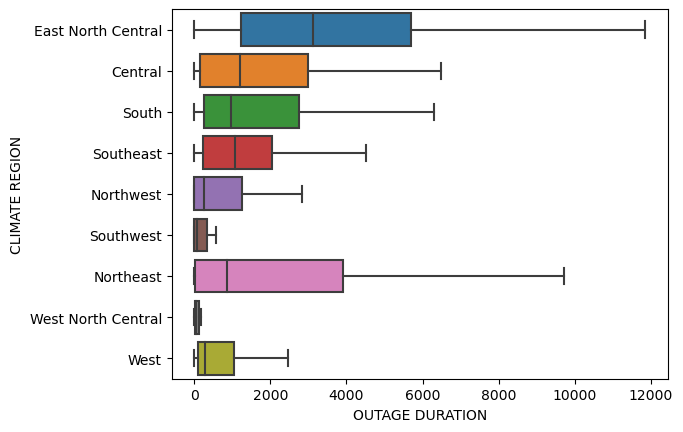

In [139]:
sns.boxplot(data=df, y='CLIMATE REGION', x='OUTAGE DURATION', showfliers=False);

*Note that for the second graph, outliers are removed.*

Looking at these graphs, the outage duration seems to be the longest and most varied in the East North Central region, while the Northeast region has a similar variance but much lower median. On the other hand, the West North Central and Southwest regions have both the least varied and shortest outage durations. For WNC, this could be simply because I don't have a lot of data in this dataset on that region, reducing the variance.

##### Customers Affected and Duration
Does it take longer to get electrical grids back up if there are more people affected by the outage? Or maybe it's the opposite: If an outage affects less people, engineers might drag their feet fixing them. Let's plot this relationship and see if there's an correlation.

In [140]:
px.scatter(df, x='CUSTOMERS AFFECTED', y='OUTAGE DURATION', 
           title='Effect of # of Customers Affected on Duration',
           trendline='ols')

Both these columns are right-skewed, as I saw before. I might have to scale them so I can see the relationship a bit better.

In [141]:
cust_vs_dur = px.scatter(
    x=np.sqrt(df['CUSTOMERS AFFECTED']), 
    y=df['OUTAGE DURATION'],
    title='Effect of # of Customers Affected on Duration',
    labels={
        'x':'Customers Affected',
        'y':'Outage Duration (min)'
    },
    trendline = 'ols')
cust_vs_dur.show()

In [142]:
df[['CUSTOMERS AFFECTED', 'OUTAGE DURATION']].corr()

,CUSTOMERS AFFECTED,OUTAGE DURATION
CUSTOMERS AFFECTED,1.000000,0.258779
OUTAGE DURATION,0.258779,1.000000


There seems to be a very weak, but positive, correlation. However, it's really too weak to tell us much about actual effects.

##### Cause and Duration
Do outages caused by different things take longer to fix? Intuition tells us yes: Things that had more severe causes might take longer to repair.

In [143]:
px.box(df, x='CAUSE CATEGORY', y='OUTAGE DURATION')

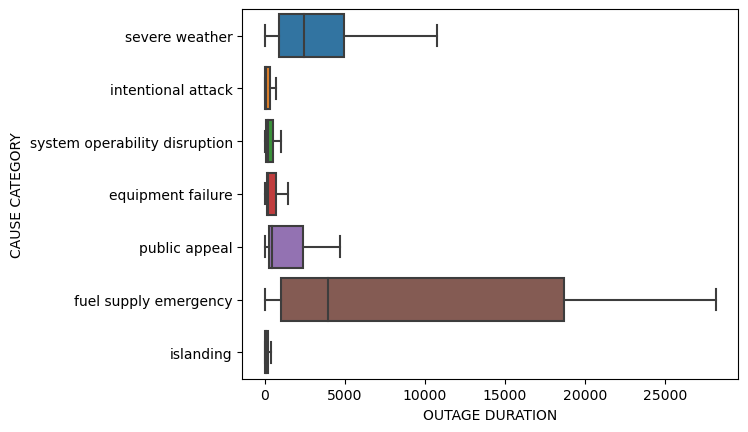

In [144]:
sns.boxplot(data=df, y='CAUSE CATEGORY', x='OUTAGE DURATION', showfliers=False);

Looking at this, it looks like fuel supply emergencies caused the longest durations, but also had the largest variance. Severe weather also caused pretty substantial outages.

In [145]:
px.bar(df.corr()['OUTAGE DURATION'].sort_values(ascending=True).drop('OUTAGE DURATION', axis=0))

### Interesting Aggregates
In this section, we'll aggregate some of the columns to make new ones and take a look at their distributions.

#### Outage Start/Resolution
First, we'll combine the `OUTAGE START DATE` and `OUTAGE START TIME` columns into one, `OUTAGE.START`. This will make the time data easier to work with. We'll also convert the values to `pd.Timestamp` objects.

In [146]:
(df[['OUTAGE START DATE', 'OUTAGE START TIME']]).head() # for reference

,OUTAGE START DATE,OUTAGE START TIME
1,"Friday, July 1, 2011",5:00:00 PM
2,"Sunday, May 11, 2014",6:38:00 PM
3,"Tuesday, October 26, 2010",8:00:00 PM
4,"Tuesday, June 19, 2012",4:30:00 AM
5,"Saturday, July 18, 2015",2:00:00 AM


In [147]:
outage_date = pd.to_datetime(df['OUTAGE START DATE'])
outage_time = pd.to_timedelta(df['OUTAGE START TIME'])
outage_start = outage_date + outage_time
outage_start.head()

1   2011-07-01 05:00:00
2   2014-05-11 06:38:00
3   2010-10-26 08:00:00
4   2012-06-19 04:30:00
5   2015-07-18 02:00:00
dtype: datetime64[ns]

In [148]:
df['OUTAGE START'] = outage_start
df.head(3)

,YEAR,MONTH,U S STATE,POSTAL CODE,NERC REGION,CLIMATE REGION,ANOMALY LEVEL,CLIMATE CATEGORY,OUTAGE START DATE,OUTAGE START TIME,OUTAGE RESTORATION DATE,OUTAGE RESTORATION TIME,CAUSE CATEGORY,CAUSE CATEGORY DETAIL,HURRICANE NAMES,OUTAGE DURATION,DEMAND LOSS MW,CUSTOMERS AFFECTED,RES PRICE,COM PRICE,IND PRICE,TOTAL PRICE,RES SALES,COM SALES,IND SALES,TOTAL SALES,RES PERCEN,COM PERCEN,IND PERCEN,RES CUSTOMERS,COM CUSTOMERS,IND CUSTOMERS,TOTAL CUSTOMERS,RES CUST PCT,COM CUST PCT,IND CUST PCT,PC REALGSP STATE,PC REALGSP USA,PC REALGSP REL,PC REALGSP CHANGE,UTIL REALGSP,TOTAL REALGSP,UTIL CONTRI,PI UTIL OFUSA,POPULATION,POPPCT URBAN,POPPCT UC,POPDEN URBAN,POPDEN UC,POPDEN RURAL,AREAPCT URBAN,AREAPCT UC,PCT LAND,PCT WATER TOT,PCT WATER INLAND,OUTAGE START
1,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",5:00:00 PM,"Sunday, July 3, 2011",8:00:00 PM,severe weather,NaN,NaN,3060.0,NaN,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736.0,276286.0,10673.0,2595696.0,88.9448,10.6440,0.4112,51268.0,47586.0,1.077376,1.6,4802.0,274182.0,1.751391,2.2,5348119.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 05:00:00
2,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",6:38:00 PM,"Sunday, May 11, 2014",6:39:00 PM,intentional attack,vandalism,NaN,1.0,NaN,NaN,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860.0,284978.0,9898.0,2640737.0,88.8335,10.7916,0.3748,53499.0,49091.0,1.089792,1.9,5226.0,291955.0,1.790002,2.2,5457125.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 06:38:00
3,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",8:00:00 PM,"Thursday, October 28, 2010",10:00:00 PM,severe weather,heavy wind,NaN,3000.0,NaN,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291.0,276463.0,10150.0,2586905.0,88.9206,10.6870,0.3924,50447.0,47287.0,1.066826,2.7,4571.0,267895.0,1.706266,2.1,5310903.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 08:00:00


Now we'll do the same for `OUTAGE RESTORATION DATE` and `OUTAGE RESTORATION TIME`, to create `OUTAGE RESTORATION`.

In [149]:
rest_date = pd.to_datetime(df['OUTAGE RESTORATION DATE'])
rest_time = pd.to_timedelta(df['OUTAGE RESTORATION TIME'])
rest_start = rest_date + rest_time
df['OUTAGE RESTORATION'] = rest_start
df.head(3)

,YEAR,MONTH,U S STATE,POSTAL CODE,NERC REGION,CLIMATE REGION,ANOMALY LEVEL,CLIMATE CATEGORY,OUTAGE START DATE,OUTAGE START TIME,OUTAGE RESTORATION DATE,OUTAGE RESTORATION TIME,CAUSE CATEGORY,CAUSE CATEGORY DETAIL,HURRICANE NAMES,OUTAGE DURATION,DEMAND LOSS MW,CUSTOMERS AFFECTED,RES PRICE,COM PRICE,IND PRICE,TOTAL PRICE,RES SALES,COM SALES,IND SALES,TOTAL SALES,RES PERCEN,COM PERCEN,IND PERCEN,RES CUSTOMERS,COM CUSTOMERS,IND CUSTOMERS,TOTAL CUSTOMERS,RES CUST PCT,COM CUST PCT,IND CUST PCT,PC REALGSP STATE,PC REALGSP USA,PC REALGSP REL,PC REALGSP CHANGE,UTIL REALGSP,TOTAL REALGSP,UTIL CONTRI,PI UTIL OFUSA,POPULATION,POPPCT URBAN,POPPCT UC,POPDEN URBAN,POPDEN UC,POPDEN RURAL,AREAPCT URBAN,AREAPCT UC,PCT LAND,PCT WATER TOT,PCT WATER INLAND,OUTAGE START,OUTAGE RESTORATION
1,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",5:00:00 PM,"Sunday, July 3, 2011",8:00:00 PM,severe weather,NaN,NaN,3060.0,NaN,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736.0,276286.0,10673.0,2595696.0,88.9448,10.6440,0.4112,51268.0,47586.0,1.077376,1.6,4802.0,274182.0,1.751391,2.2,5348119.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 05:00:00,2011-07-03 08:00:00
2,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",6:38:00 PM,"Sunday, May 11, 2014",6:39:00 PM,intentional attack,vandalism,NaN,1.0,NaN,NaN,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860.0,284978.0,9898.0,2640737.0,88.8335,10.7916,0.3748,53499.0,49091.0,1.089792,1.9,5226.0,291955.0,1.790002,2.2,5457125.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 06:38:00,2014-05-11 06:39:00
3,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",8:00:00 PM,"Thursday, October 28, 2010",10:00:00 PM,severe weather,heavy wind,NaN,3000.0,NaN,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291.0,276463.0,10150.0,2586905.0,88.9206,10.6870,0.3924,50447.0,47287.0,1.066826,2.7,4571.0,267895.0,1.706266,2.1,5310903.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 08:00:00,2010-10-28 10:00:00


In [150]:
rest_start_duration = (df['OUTAGE RESTORATION'] - df['OUTAGE START']).dt.total_seconds() // 60
df[['OUTAGE START', 'OUTAGE START TIME', 'OUTAGE RESTORATION', 'OUTAGE RESTORATION TIME', 'OUTAGE DURATION']][~(rest_start_duration == df['OUTAGE DURATION'])].assign(rsd = rest_start_duration)

,OUTAGE START,OUTAGE START TIME,OUTAGE RESTORATION,OUTAGE RESTORATION TIME,OUTAGE DURATION,rsd
4,2012-06-19 04:30:00,4:30:00 AM,2012-06-20 11:00:00,11:00:00 PM,2550.0,1830.0
8,2005-06-08 04:00:00,4:00:00 AM,2005-06-10 10:00:00,10:00:00 PM,3960.0,3240.0
10,2013-06-21 05:39:00,5:39:00 PM,2013-06-24 06:00:00,6:00:00 AM,3621.0,4341.0
15,2014-06-15 12:00:00,12:00:00 AM,2014-06-15 01:00:00,1:00:00 AM,60.0,-660.0
19,2011-04-19 10:44:00,10:44:00 PM,2011-04-20 02:00:00,2:00:00 AM,196.0,916.0
...,...,...,...,...,...,...
1528,2016-03-01 01:35:00,1:35:00 PM,NaT,NaN,NaN,NaN
1530,2011-12-06 08:00:00,8:00:00 AM,2011-12-06 08:00:00,8:00:00 PM,720.0,0.0
1531,NaT,NaN,NaT,NaN,NaN,NaN
1533,2009-08-29 11:00:00,11:00:00 AM,2009-08-29 02:01:00,2:01:00 PM,181.0,-540.0


Let's see how durations have changed over time. To do this, we'll group by the start date and take the median<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) duration for all the outages that occurred on that date. Then, we'll plot the change in this over time on a line plot.

<a name="cite_note-1"></a>1. [^](#cite_ref-1) We'll use the median here, since there are a lot of outliers in my data.

In [151]:
dur_by_date = (df.groupby('OUTAGE START')
                    ['OUTAGE DURATION']
                    .median())
px.line(dur_by_date, 
        title='Change in Outage Duration over Time',
        y='OUTAGE DURATION',
        labels={
            'OUTAGE START': 'Date of Start of Outage',
            'OUTAGE DURATION': 'Outage Duration'
        })

In [224]:
df

,YEAR,MONTH,U S STATE,POSTAL CODE,NERC REGION,CLIMATE REGION,ANOMALY LEVEL,CLIMATE CATEGORY,OUTAGE START DATE,OUTAGE START TIME,OUTAGE RESTORATION DATE,OUTAGE RESTORATION TIME,CAUSE CATEGORY,CAUSE CATEGORY DETAIL,HURRICANE NAMES,OUTAGE DURATION,DEMAND LOSS MW,CUSTOMERS AFFECTED,RES PRICE,COM PRICE,IND PRICE,TOTAL PRICE,RES SALES,COM SALES,IND SALES,TOTAL SALES,RES PERCEN,COM PERCEN,IND PERCEN,RES CUSTOMERS,COM CUSTOMERS,IND CUSTOMERS,TOTAL CUSTOMERS,RES CUST PCT,COM CUST PCT,IND CUST PCT,PC REALGSP STATE,PC REALGSP USA,PC REALGSP REL,PC REALGSP CHANGE,UTIL REALGSP,TOTAL REALGSP,UTIL CONTRI,PI UTIL OFUSA,POPULATION,POPPCT URBAN,POPPCT UC,POPDEN URBAN,POPDEN UC,POPDEN RURAL,AREAPCT URBAN,AREAPCT UC,PCT LAND,PCT WATER TOT,PCT WATER INLAND,OUTAGE START,OUTAGE RESTORATION,PROP CUST AFFECTED
1,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",5:00:00 PM,"Sunday, July 3, 2011",8:00:00 PM,severe weather,NaN,NaN,3060.0,90.0,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736.0,276286.0,10673.0,2595696.0,88.9448,10.6440,0.4112,51268.0,47586.0,1.077376,1.6,4802.0,274182.0,1.751391,2.2,5348119.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2011-07-01 05:00:00,2011-07-03 08:00:00,0.026968
2,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",6:38:00 PM,"Sunday, May 11, 2014",6:39:00 PM,intentional attack,vandalism,NaN,1.0,0.0,0.0,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860.0,284978.0,9898.0,2640737.0,88.8335,10.7916,0.3748,53499.0,49091.0,1.089792,1.9,5226.0,291955.0,1.790002,2.2,5457125.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2014-05-11 06:38:00,2014-05-11 06:39:00,0.000000
3,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",8:00:00 PM,"Thursday, October 28, 2010",10:00:00 PM,severe weather,heavy wind,NaN,3000.0,72.0,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291.0,276463.0,10150.0,2586905.0,88.9206,10.6870,0.3924,50447.0,47287.0,1.066826,2.7,4571.0,267895.0,1.706266,2.1,5310903.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2010-10-26 08:00:00,2010-10-28 10:00:00,0.027059
4,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Tuesday, June 19, 2012",4:30:00 AM,"Wednesday, June 20, 2012",11:00:00 PM,severe weather,thunderstorm,NaN,2550.0,700.0,68200.0,11.79,9.25,6.71,9.19,1851519.0,1941174.0,1993026.0,5787064.0,31.994099,33.543330,34.439329,2317336.0,278466.0,11010.0,2606813.0,88.8954,10.6822,0.4224,51598.0,48156.0,1.071476,0.6,5364.0,277627.0,1.932089,2.2,5380443.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 11:00:00,0.026162
5,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,"Saturday, July 18, 2015",2:00:00 AM,"Sunday, July 19, 2015",7:00:00 AM,severe weather,NaN,NaN,1740.0,250.0,250000.0,13.07,10.16,7.74,10.43,2028875.0,2161612.0,1777937.0,5970339.0,33.982576,36.205850,29.779498,2374674.0,289044.0,9812.0,2673531.0,88.8216,10.8113,0.3670,54431.0,49844.0,1.092027,1.7,4873.0,292023.0,1.668704,2.2,5489594.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00,0.093509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2016.0,7.0,Idaho,ID,WECC,Northwest,-0.3,normal,"Tuesday, July 19, 2016",3:45:00 PM,"Tuesday, July 19, 2016",7:25:00 PM,system operability disruption,uncontrolled loss,NaN,220.0,485.0,400000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,714365.0,107551.0,27847.0,849763.0,84.0664,12.6566,3.2770,36256.0,50660.0,0.715673,2.7,960.0,60911.0,1.576070,0.4,1680026.0,70.58,20.06,2216.

My data's too fine-grained to see overall trends. Let's try just taking the median over each year.

In [152]:
dur_by_yr = df.assign(startyr = df['OUTAGE START'].dt.year)
dur_by_yr = dur_by_yr.groupby('startyr')['OUTAGE DURATION'].median()
dur_by_yr

startyr
2000.0    1230.0
2001.0     278.5
2002.0    3210.0
2003.0    2019.5
2004.0    1950.0
2005.0    3060.0
2006.0    1793.0
2007.0    1003.0
2008.0    1092.0
2009.0    1204.0
2010.0    1683.5
2011.0     457.0
2012.0     255.0
2013.0     184.5
2014.0     235.5
2015.0     176.5
2016.0     224.0
Name: OUTAGE DURATION, dtype: float64

In [153]:
px.line(dur_by_yr, 
        title='Change in Outage Duration over Time',
        y='OUTAGE DURATION',
        labels={
            'startyr': 'Year',
            'OUTAGE DURATION': 'Outage Duration'
        })

This seems to suggest outage duration has been on the decline since around 2004. However, keep in mind from earlier: I have a lot more data for the more recent years, meaning there is probably a higher variance in the earlier years, which could lead to the perceived decline. I could've just gotten really unlucky, and the outages that were recorded from 2002-06 happened to be really long. 

#### Proportion of Customers affected
Something I might also use to measure severity is how many people were affected. However, since the total number of customers in each region could vary, it'd be unhelpful to look at the raw totals. Let's make a column, `PROP CUST AFFECTED`, that tells us what proportion of annual customers for that state were affected by the outage.

In [154]:
df['PROP CUST AFFECTED'] = df['CUSTOMERS AFFECTED'] / df['TOTAL CUSTOMERS']
df[['CUSTOMERS AFFECTED', 'TOTAL CUSTOMERS', 'PROP CUST AFFECTED']].head()

,CUSTOMERS AFFECTED,TOTAL CUSTOMERS,PROP CUST AFFECTED
1,70000.0,2595696.0,0.026968
2,NaN,2640737.0,NaN
3,70000.0,2586905.0,0.027059
4,68200.0,2606813.0,0.026162
5,250000.0,2673531.0,0.093509


In [155]:
px.histogram(df, x='PROP CUST AFFECTED')

Since the distribution of total customers affected was heavily right-skewed, this distribution makes sense.

#### Severity by Location
Does the location have some correlation with outage severity (in terms of length and proportion of customers affected)? I can plot a choropleth map to see if there are any trends. Since I only have data for states, we'll do this on the state level.

In [156]:
# Grouping by states and getting median stats
# Median is used again here since our data is heavily skewed
grouped = df.groupby('POSTAL CODE').median().get(['OUTAGE DURATION', 'PROP CUST AFFECTED']).sort_values('OUTAGE DURATION', ascending=False).reset_index()
grouped.head()

,POSTAL CODE,OUTAGE DURATION,PROP CUST AFFECTED
0,WV,5288.0,0.204557
1,MI,4110.0,0.025650
2,NJ,3120.5,0.034682
3,SC,2947.5,0.060589
4,PA,2880.0,0.020991


In [157]:
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data= "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json",
    name="choropleth",
    data=grouped,
    columns=["POSTAL CODE", "OUTAGE DURATION"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="OUTAGE DURATION",
).add_to(m)

folium.LayerControl().add_to(m)

m

*The States in black are States with no recorded Outage Duration.*

This table was grouped by US State and aggregated by median. I can see that Eastern States seem to have longer median outage durations.

## Step 3: Assessment of Missingness
In this section, we'll be going over the missingness in some of the columns of my dataset, and the mechanisms that they might follow.

Here are the columns that are missing at least one value:

In [158]:
missingness = pd.DataFrame(df.isna().sum())
missingness.T#[missingness[0] > 0].T

,YEAR,MONTH,U S STATE,POSTAL CODE,NERC REGION,CLIMATE REGION,ANOMALY LEVEL,CLIMATE CATEGORY,OUTAGE START DATE,OUTAGE START TIME,OUTAGE RESTORATION DATE,OUTAGE RESTORATION TIME,CAUSE CATEGORY,CAUSE CATEGORY DETAIL,HURRICANE NAMES,OUTAGE DURATION,DEMAND LOSS MW,CUSTOMERS AFFECTED,RES PRICE,COM PRICE,IND PRICE,TOTAL PRICE,RES SALES,COM SALES,IND SALES,TOTAL SALES,RES PERCEN,COM PERCEN,IND PERCEN,RES CUSTOMERS,COM CUSTOMERS,IND CUSTOMERS,TOTAL CUSTOMERS,RES CUST PCT,COM CUST PCT,IND CUST PCT,PC REALGSP STATE,PC REALGSP USA,PC REALGSP REL,PC REALGSP CHANGE,UTIL REALGSP,TOTAL REALGSP,UTIL CONTRI,PI UTIL OFUSA,POPULATION,POPPCT URBAN,POPPCT UC,POPDEN URBAN,POPDEN UC,POPDEN RURAL,AREAPCT URBAN,AREAPCT UC,PCT LAND,PCT WATER TOT,PCT WATER INLAND,OUTAGE START,OUTAGE RESTORATION,PROP CUST AFFECTED
0,0,9,0,0,0,6,9,9,9,9,58,58,0,471,1462,58,705,443,22,22,22,22,22,22,22,22,22,22,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,0,0,0,0,0,9,58,443


### NMAR Analysis
One column that could be NMAR, meaning the missingness of the data depends on some property of the missing data itself, is '`OUTAGE RESTORATION DATE`'. This is because restoration dates could have started being recorded after a certain date. Restoration dates before that date would be missing. The additional data I would want to obtain would be when they started recording restoration dates, and the dates for outage restorations before they started recording restorations.

### Missingness Dependency
In this section, we'll run some tests to see if the missingness in certain columns of the dataset is dependent on any other columns.

Let's start off by defining some functions to avoid repeating code. These might be used later on as well, to test other hypotheses.

In [159]:
# tvd function from lecture 8, slightly modified to work more generally
def tvd_of_groups(df, cats, groups):
    '''groups: the binary column (e.g. married vs. unmarried).
       cats: the categorical column (e.g. employment status).
    '''
    cnts = df.pivot_table(index=groups, columns=cats, aggfunc='size')
    # Normalize each column.
    distr = cnts / cnts.sum()
    # Compute and return the TVD.
    return (distr.iloc[:,0] - distr.iloc[:,1]).abs().sum() / 2

# abs diff of means function
def abs_diff_means(df, quant, groups):
    """
    groups: binary column
    quant: quantitative column
    """
    grouped = df.groupby(groups).mean()
    diff = grouped.diff().iloc[-1][quant]
    return np.abs(diff)

In [160]:
# Runs a permutation test
def perm_test(df, col1, col2, N=500, showplot=False, debug=False, test_statistic=None):
    """
    col1: Binary Column
    col2: Other Column
    """
    # permutation test
    df = df.copy()
    # Step 1: Calculate observed test statistic
    # **Picking test statistic
    ts_functions = {
        'tvd': tvd_of_groups,
        'abs diff means': abs_diff_means
    }
    if not test_statistic:
        calc_ts = abs_diff_means if df[col2].dtype == float else tvd_of_groups
    elif callable(test_statistic):
        calc_ts = test_statistic
    else:
        try:
            calc_ts = ts_functions[test_statistic]
        except KeyError as e:
            raise KeyError(f'Invalid Test Statistic "{test_statistic}"')

    if debug:
        print("Calculating with", calc_ts)
    
    obs_ts = calc_ts(df, col2, col1)

    # Step 2: generate N simulated tvds
    sim_test_stats=[]
    for _ in range(N):
        df['shuffled_col'] = np.random.permutation(df[col2])
        sim_ts = calc_ts(df, 'shuffled_col', col1)
        sim_test_stats.append(sim_ts)

    # Step 3: calculate p-value, extreme direction is to the right (greater than)
    p_val = (np.array(sim_test_stats) >= obs_ts).mean()
    if showplot:
        fig = px.histogram(sim_test_stats, 
                           nbins=20, 
                           title=f'Simulated and Observed {calc_ts.__name__} from Permutation Test',
                           labels={
                               'value': calc_ts.__name__
                           })
        fig.add_vline(obs_ts)
        fig.show()
    if debug:
        return p_val, sim_test_stats
    return p_val

# Runs a perm test, specifically to determine missingness dependency
def missingness_perm_test(df, missing_col, col, N=500, showplot=False, debug=False, test_statistic=None):
    """Runs a missingness permutation test on the column given
    """
    # make a mini dataframe with only columns of interest
    df_mini = df[[missing_col, col]].copy()
    df_mini[missing_col] = df_mini[missing_col].isna()

    return perm_test(df_mini, missing_col, col, N=N, showplot=showplot, debug=debug, test_statistic=test_statistic)

In [161]:
# plot distribution difference for a given column based on missingness in another column
def plot_missing_diff(df, miss, col, barmode=''):
    """Plots difference in distribution for a categorical column between missing
    and present data in another column.
    
    df: data
    miss: name of column with missing data
    col: name of column to plot distribution of
    """
    mode = (barmode if barmode
            else 'overlay' if df[col].dtype in ['float', 'int'] 
            else 'group')
    return px.histogram(df.assign(missing=df[miss].isna()),
                x=col,
                color='missing',
                histnorm='probability density',
                title=f'Distribution of {col} between Missing and Present {miss}',
                barmode=mode,
                color_discrete_map={
                    True: '#ff7f0e',
                    False: '#1f77b4'
                })

In [162]:
df['OUTAGE DURATION'].isna().sum() / df.shape[0]

0.03780964797913951

In my dataset, the `'OUTAGE DURATION'` column, which I am interested in as a measure of outage severity, is missing some of its values. This is problematic, and I want to know which missingness mechanism it follows so that I can impute values and closely replicate the missing data.

One way to check this is to look at the difference in the distributions of a column between rows where duration is missing and rows where it's present. This is demonstrated for `'CAUSE CATEGORY'` below.

In [163]:
plot_missing_diff(df, 'OUTAGE DURATION', 'CAUSE CATEGORY')

The rows of "severe weather" seem to be missing duration less, while "fuel supply emergency" seems to be missing it more. Based on this difference in distributions, I believe that the `'OUTAGE DURATION'` Column is Missing at Random (MAR) depending on the `'CAUSE CATEGORY'` column. To test this theory, we'll run a permutation test on these two columns.
***
#### **H<sub>0</sub>**: The distribution of Cause Category is the same for rows that are missing Outage Duration and rows that are not missing Outage Duration.

#### **H<sub>a</sub>**: The distribution of Cause Category is *different* for rows that are missing Outage Duration and rows that are not missing Outage Duration.

##### Test Statistic: The Total Variation Distance between the distributions of Cause Category for rows missing Outage Duration and rows not missing Outage Duration.

Significance level: $\alpha = 0.05$
***

In [164]:
p_val = missingness_perm_test(df, 'OUTAGE DURATION', 'CAUSE CATEGORY')
print(f'P-value: {p_val}')

P-value: 0.0


Based on the results of my permutation test, I reject the null hypothesis. I rarely see TVD's as high as my observed. This tells us that the missingness of Outage Duration does depend on Cause Category, making it NMAR. To replace these values, I should employ **probabilistic imputation**, replacing each missing duration value with a randomly sampled value from the durations with the same cause category.

Let's run the same test on some other columns, to see if the missingness in Duration is dependant on anything else.

In [165]:
plot_missing_diff(df, 'OUTAGE DURATION', 'MONTH', barmode='group')

I can see that the distribution of month looks about the same regardless of the missingness of Duration. Let's see if that tiny difference is significant.

In [166]:
p_val = missingness_perm_test(df, 'OUTAGE DURATION', 'MONTH', test_statistic='tvd')
print(f'P-value: {p_val}')

P-value: 0.88


As expected, the p-value is high, beyond the chosen significance threshold of 0.05. This means that Outage Duration is Not Missing at Random (NMAR) in relation to Month.

When I decide how to impute this data (if I decide to impute it later on), all of these will come into play.

Another column we're interested in that is missing a lot of values is the `'CUSTOMERS AFFECTED'` column. Let's do the same sort of analysis with this column.

First, we'll look at `'TOTAL CUSTOMERS'`. It's easy to theorize how total number of customers could affect the missingness: Places with less customers might not have bothered to track how many were affected since so little were, or places with more might not have since so many were it'd be hard to keep track. Let's test this theory in the same way.
***
#### **H<sub>0</sub>**: The distribution of Total Customers is the same for rows that are missing Customers Affected Duration and rows that are not missing Customers Affected.

#### **H<sub>a</sub>**: The distribution of Total Customers is *different* for rows that are missing Customers Affected Duration and rows that are not missing Customers Affected.

##### Test Statistic: Absolute Difference in Means*

Significance level: $\alpha = 0.05$
***
**Note that I am using absolute difference in means as my test statistic this time. This is because Total Customers is quantitative data: it wouldn't make sense to split it into categories and calculate the TVD.*

In [167]:
plot_missing_diff(df, 'CUSTOMERS AFFECTED', 'TOTAL CUSTOMERS')

In [168]:
p_val=missingness_perm_test(df, 'CUSTOMERS AFFECTED', 'TOTAL CUSTOMERS')
print(f'P-value: {p_val}')

P-value: 0.816


This p-value is also above my significance level of 0.05. This means that I fail to reject the null: there's not enough evidence to say that the missingness of Customers Affected is affected by the value in Total Customers.

Cause Category caused missingness in my other severity metric. Let's see if it also affects Customers Affected:

In [169]:
plot_missing_diff(df, 'CUSTOMERS AFFECTED', 'CAUSE CATEGORY') 

In [170]:
p_val = missingness_perm_test(df, 'CUSTOMERS AFFECTED', 'CAUSE CATEGORY')
print(f'P-value: {p_val}')

P-value: 0.0


I can see from this p-value that it does affect Customers Affected. Again, if I want to impute values later on, this analysis will be important to keep in mind.

My final severity measure is `'DEMAND LOSS MW'`, which is the peak demand lost (in megawatts) during an outage. Since this has been the trend, let's see if cause category affects the missingness here.

In [171]:
plot_missing_diff(df, 'DEMAND LOSS MW', 'CAUSE CATEGORY')

In [172]:
missingness_perm_test(df, 'DEMAND LOSS MW', 'CAUSE CATEGORY')

0.0

As I might have suspected, this is also MAR depending on Cause Category.

### Imputation
Now, we'll fill the missing values in Outage Duration so that I can use them for prediction later on. To do this, for every missing value in `'OUTAGE DURATION'`, we'll randomly sample a present value from the same Cause Category (since it was shown to affect missingness) to fill it with. 

In [173]:
# Probabilistic imputation function taken from Lecture 8
def prob_impute(s):
    s = s.copy()
    
    num_null = s.isna().sum()
    
    fill_values = np.random.choice(s.dropna(), num_null)

    s[s.isna()] = fill_values
    return s

In [174]:
# Drop Alaska, since its missing all of its durations
temp = df[df['POSTAL CODE'] != 'AK'].copy(deep=True)
filled_durations = temp.groupby('CAUSE CATEGORY')['OUTAGE DURATION'].transform(prob_impute)
temp['OUTAGE DURATION'] = filled_durations
df = temp

We'll perform the same imputation method on `'CUSTOMERS AFFECTED'` and `'DEMAND LOSS MW'`, so I can use them later for prediction.

In [175]:
np.random.seed(455) # for consistency
temp = df.copy()
filled_customers = temp.groupby('CAUSE CATEGORY')['CUSTOMERS AFFECTED'].transform(prob_impute)
temp['CUSTOMERS AFFECTED'] = filled_customers
filled_demand = temp.groupby('CAUSE CATEGORY')['DEMAND LOSS MW'].transform(prob_impute)
temp['DEMAND LOSS MW'] = filled_demand
filled_prop = temp.groupby('CAUSE CATEGORY')['PROP CUST AFFECTED'].transform(prob_impute)
temp['PROP CUST AFFECTED'] = filled_prop
df = temp

## Step 4: Hypothesis Testing
In this section, we'll pick some questions about my data to answer with some hypothesis testing. We'll refer back to trends found during EDA to formulate some interesting questions.

### Question 1: Are the durations of outages in the East North Central region significantly longer than the overall population?
Since we're interested in predicting Outage Duration as one metric for severity, it'd be helpful to know what factors affect this. In my EDA, I saw that the East North Central region had a higher median outage duration than other regions. This was backed up in my aggregate analysis. Is this a significant difference?

Before running my hypothesis test, let's take a look at the data and see how different they really are.

In [176]:
mean_ENC = df[df['CLIMATE REGION'] == 'East North Central']['OUTAGE DURATION'].mean()
mean_other = df[df['CLIMATE REGION'] != 'East North Central']['OUTAGE DURATION'].mean()
print(mean_ENC - mean_other)
data = pd.DataFrame()
data['Climate Region'] = ['East North Central', 'Other']
data['Mean Duration (min)'] = [mean_ENC, mean_other]
px.bar(data,
       x='Climate Region',
       y='Mean Duration (min)',
       title='Outage Durations by Climate Region'
       )

2878.0820321022284


So in my observed data, there's a 2878 minute difference between the mean durations for ENC and other regions. Let's see if this difference is significant using a permutation test.
***
#### **H<sub>0</sub>**: The mean duration of outages in the East North Central region is the same as the mean duration of outages in other regions.

#### **H<sub>0</sub>**: The mean duration of outages in the East North Central region *longer than* the mean duration of outages in other regions.

##### Test statistic: Absolute Difference in Mean Duration between the ENC region and other regions.

Significance level: $\alpha=0.05$
***
To do this we'll have to create a dataframe where one of the columns is binary, which takes on one value for "ENC" and another value for "not ENC".

In [177]:
data = df[['CLIMATE REGION', 'OUTAGE DURATION']]
data['Region Binarized'] = data['CLIMATE REGION'].where(data['CLIMATE REGION'] == 'East North Central', 'Other')
data

,CLIMATE REGION,OUTAGE DURATION,Region Binarized
1,East North Central,3060.0,East North Central
2,East North Central,1.0,East North Central
3,East North Central,3000.0,East North Central
4,East North Central,2550.0,East North Central
5,East North Central,1740.0,East North Central
...,...,...,...
1529,Northwest,220.0,Other
1530,West North Central,720.0,Other
1531,West North Central,1676.0,Other
1532,West North Central,59.0,Other


In [178]:
# running our permutation test on duration and binarized region
# custom diff of means function
def diff_means(df, quant, groups):
    """
    groups: binary column
    quant: quantitative column
    """
    grouped = df.groupby(groups).mean()
    # Since ENC is before Other in the alphabet, .diff() gives us Other - ENC, so we correct for that
    diff = grouped.diff().iloc[-1][quant] * -1
    return diff
p_val=perm_test(data, 'Region Binarized', 'OUTAGE DURATION', N=1000, showplot=True, test_statistic=diff_means)
print(f'P-value: {p_val}')

P-value: 0.0


From the results of my permutation test, I can conclude that I reject the null hypothesis. The mean duration in the East North Central region is significantly different from the mean duration in other regions.

## Step 5: Framing a Prediction Problem

My prediction problem: **Predict the severity (measured in Outage Duration) of an outage by looking at data from any of the cause columns.** To solve this problem, I will be using **regression**, since I want to predict the duration, not classify the data. The response variable is **Outage Duration**. To evaluate my model, I will be using $R^2$, since it is more straightforward metric, where higher values are better (as opposed to RMSE, where lower error is better).

## Step 6: Baseline Model

First, we'll train a baseline model with just 2 features, so I have something to compare my final model to. 

Before that, recall that the outage durations were heavily skewed right. This was due to a small number of outliers in the data. For our purposes, we'll drop any extreme values (defined as any outages lasting longer than a week). This will make my final model less accurate for durations longer than a week, but since most durations fall behind that threshold, it shouldn't hurt too much. More importantly, it'll make it *more accurate* for predicting durations shorter than a week, which is where the majority of my durations lie.

In [179]:
threshold = 60 * 24 * 7
df_new = df[df['OUTAGE DURATION'] <= threshold]
print(f'We still have {np.round(df_new.shape[0]/df.shape[0] * 100, 2)}% of our data left!')

We still have 94.06% of our data left!


Now, let's take a look at the correlations of each numerical feature with respect to Outage Duration, to get a sense of which features to use for my baseline.

In [180]:
correlations = df_new.corr()['OUTAGE DURATION']
correlations.abs().sort_values(ascending=False).head(11)

OUTAGE DURATION       1.000000
PCT LAND              0.248122
PCT WATER TOT         0.248107
CUSTOMERS AFFECTED    0.238029
YEAR                  0.221577
PROP CUST AFFECTED    0.211347
UTIL CONTRI           0.141452
POPDEN RURAL          0.129452
PC REALGSP USA        0.127483
POPPCT UC             0.126656
RES CUST PCT          0.123316
Name: OUTAGE DURATION, dtype: float64

In [181]:
correlations['PCT LAND']

-0.2481219535874372

This tells us the top ten most correlated (calculated with absolute correlation) columns with respect to outage duration. From this, I can see that the percentage of land area in the state (compared to the overall land in the continental US) is moderately correlated with duration. The correlation is negative, meaning the larger the state, the shorted the outage. We'll use this as one of my baseline model's features.

In [182]:
correlations['CUSTOMERS AFFECTED']

0.23802925986728252

Another measure that is moderately correlated with duration is Customers Affected (we also saw this in the EDA). It seems like as more customers are affected, it takes longer to restore power. We'll use this as the other feature in my baseline.

#### Baseline Model Description
The baseline model will use the features Pct. Land and Customers Affected. Both these features are continuous, quantitative features, so no encodings were necessary.

In [225]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_new[['PCT LAND', 'CUSTOMERS AFFECTED']]  
y = df_new['OUTAGE DURATION']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_pipeline = Pipeline(steps=[
    ('regressor', LinearRegression()) 
])
base_pipeline.fit(X_train, y_train)

# Evaluating the model on the test set
base_score = base_pipeline.score(X_test, y_test)
print("Baseline Model R^2 Score:", base_score)

Baseline Model R^2 Score: -0.014154394710215623


This baseline model is not very good, as can be seen by the very low $R^2$ score. This is likely because even though I picked the best features based on correlation, the highest correlation score did not exceed 0.3, so it was still pretty low as-is. Hopefully, I can improve on this score in my final model.

## Step 7: Final Model
Now we'll try to define a pipeline to improve on this baseline model.

We'll be iteratively making changes to my base pipeline and checking the scores to see if it improved. It'd be nice to have a function to do this rather than copy-pasting code all the time.

In [226]:
scores = pd.DataFrame(columns = ['Model', 'Train', 'Test'])
def check_score(X, y, pipeline, name=''):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    if not name:
        name = "Pipeline"
    diff = score - base_score
    pref = 'higher' if diff > 0 else 'lower'
    print(f"{name} R^2 Score on train: {train_score}")
    print(f"{name} R^2 Score on test: {score} \n {np.abs(diff)} {pref} than base")
    return train_score, score

In [227]:
train, test = check_score(X, y, base_pipeline, name='Base') 
scores.loc[scores.shape[0]] = ['Base', train, test]

Base R^2 Score on train: 0.13380816236618398
Base R^2 Score on test: -0.014154394710215623 
 0.0 lower than base


Firstly, I want to include some of my categorical features as well as the numerical features. I can't directly calculate the correlation of these with the duration. However, I know from my EDA that the duration varied based on Climate Region, and that certain states also had higher median durations. The same is true for Cause Category: differing cause categories had large effects on the duration. Let's see if these are true after removing extreme values.

In [228]:
def plot_multiple_graphs(*figures, titles=[]):
    """ code in this cell largely borrowed from:
    https://stackoverflow.com/questions/56727843/how-can-i-create-subplots-with-plotly-express """
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    # For as many traces that exist per Express figure, get the traces from each plot and store them in an array.
    # This is essentially breaking down the Express fig into it's traces


    #Create a 1x2 subplot
    if not titles:
        titles = [f'Plot {i}' for i in range(1, len(figures)+1)]
    fig = make_subplots(rows=1, cols=len(figures), subplot_titles=titles) 

    for i, figure in enumerate(figures):
        for trace in range(len(figure["data"])):
            fig.append_trace(figure["data"][trace], row=1, col=i+1)

    #the subplot as shown in the above image
    return fig

In [229]:
figure1 = px.box(df_new, x='CLIMATE REGION', y='OUTAGE DURATION')
figure2 = px.box(df_new, x='CAUSE CATEGORY', y='OUTAGE DURATION')
titles = ['Distribution of Duration by Climate Region','Distribution of Duration by Cause Category']
figures = [figure1, figure2]
plot_multiple_graphs(figure1, figure2, titles=titles)

The distributions are still there. We'll add this column as a feature in my pipeline, one-hot-encoding it. We'll also drop the first encoded column, to avoid multicollinearity and make sure my coefficients make sense later.

In [230]:
num_features = ['PCT LAND', 'CUSTOMERS AFFECTED']
cat_features = ['CLIMATE REGION', 'CAUSE CATEGORY']
ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
], remainder='passthrough')

cat_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])
X = df_new[num_features + cat_features]  
y = df_new['OUTAGE DURATION']

In [231]:
train, test = check_score(X, y, cat_pipe) 
scores.loc[scores.shape[0]] = ['Cat', train, test]

Pipeline R^2 Score on train: 0.32290408306883733
Pipeline R^2 Score on test: 0.2073885236037709 
 0.22154291831398654 higher than base


So we've made a significant improvement! However, my $R^2$ is still pretty low.

Another thing I might try is performing transformations on the quantitative features we're using. As I saw earlier in the EDA, my Customers Affected column was heavily right-skewed. I haven't removed outliers from that column, so let's see if I can sqrt transform it to make it fit a linear model better.

In [232]:
from sklearn.preprocessing import FunctionTransformer
num_features = ['PCT LAND', 'CUSTOMERS AFFECTED']
cat_features = ['CLIMATE REGION', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('sqrt customers', FunctionTransformer(np.sqrt), ['CUSTOMERS AFFECTED'])
], remainder='passthrough')

sqrt_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])
X = df_new[num_features + cat_features]  
y = df_new['OUTAGE DURATION']

In [233]:
train, test = check_score(X, y, sqrt_pipe) 
scores.loc[scores.shape[0]] = ['Sqrt', train, test]

Pipeline R^2 Score on train: 0.363511859183109
Pipeline R^2 Score on test: 0.2420362739846712 
 0.2561906686948868 higher than base


It did improve my model, but it's still not great, considering $R^2$ ranges from 0 to 1.

I saw in my EDA that outage duration varied wildly from state to state. Let's add `'U S STATE'` in my categorical features and see if that helps.

In [234]:
num_features = ['PCT LAND', 'CUSTOMERS AFFECTED']
cat_features = ['U S STATE', 'CLIMATE REGION', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('sqrt customers', FunctionTransformer(np.sqrt), ['CUSTOMERS AFFECTED'])
], remainder='passthrough')

state_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])
X = df_new[num_features + cat_features]  
y = df_new['OUTAGE DURATION']

In [235]:
train, test = check_score(X, y, state_pipe) 
scores.loc[scores.shape[0]] = ['State', train, test]

Pipeline R^2 Score on train: 0.40826623180418864
Pipeline R^2 Score on test: 0.2518227706911078 
 0.26597716540132343 higher than base


That improved the performance a good amount. I also noticed if I removed `'PCT LAND'` and `'CLIMATE REGION'` from my features, it doesn't affect the performance that much. Perhaps these were giving the same information as `'U S STATE'`, since every state has a different percent land (so rows with the same value for state would have the same value for pct. land), and climate region is just a coarser-grained determination of location.

What if I were to use the proportion of customers affected instead of the total number? That might remove some bias for more populated areas having more customers affected. I made the `'PROP CUST AFFECTED'` column earlier, so we'll replace `'CUSTOMERS AFFECTED'` with it.

In [236]:
num_features = ['PROP CUST AFFECTED']
cat_features = ['U S STATE', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('sqrt customers', FunctionTransformer(np.sqrt), ['PROP CUST AFFECTED'])
], remainder='passthrough')

prop_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])
X = df_new[num_features + cat_features]
y = df_new['OUTAGE DURATION']

In [237]:
train, test = check_score(X, y, prop_pipe) 
scores.loc[scores.shape[0]] = ['Props', train, test]

Pipeline R^2 Score on train: 0.4037011880239306
Pipeline R^2 Score on test: 0.24540016336313075 
 0.2595545580733464 higher than base


This dropped the performance slightly. We'll stick to just using `'CUSTOMERS AFFECTED'` for now.

The final severity measure in the dataset was demand loss. Since Customers (another severity measure) seemed to have a large effect on duration, perhaps adding in demand loss will improve it even more.

Recall from the univariate analysis that demand loss is heavily right-skewed, just like duration and customers. For this reason, we'll also perform a sqrt transform on it.

In [238]:
num_features = ['PROP CUST AFFECTED', 'DEMAND LOSS MW']
cat_features = ['U S STATE', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('sqrt customers', FunctionTransformer(np.sqrt), ['PROP CUST AFFECTED', 'DEMAND LOSS MW'])
], remainder='passthrough')

demand_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])
X = df_new[num_features + cat_features]
y = df_new['OUTAGE DURATION']

In [239]:
train, test = check_score(X, y, demand_pipe) 
scores.loc[scores.shape[0]] = ['Demand', train, test]

Pipeline R^2 Score on train: 0.40408751312911195
Pipeline R^2 Score on test: 0.24327183640869876 
 0.2574262311189144 higher than base


Adding in demand loss seemed to decrease performance, so we'll leave it out of the final model.

What about Year and Month? In the EDA, I saw that the number of outages that happened was dependant on the month, and that durations fluctuated heavily from year to year. Maybe adding in these features can help my performance. Month is missing some values though, so we'll have to handle that first.

In [240]:
df_new.isna().sum()['MONTH']

0

In [241]:
# Only missing 8 values, we'll drop them
df_new = df_new[df_new['MONTH'].notna()]
df_new.isna().sum()['MONTH']

0

In [242]:
num_features = ['PROP CUST AFFECTED', 'DEMAND LOSS MW', 'YEAR', 'MONTH']
cat_features = ['U S STATE', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('sqrt customers', FunctionTransformer(np.sqrt), ['PROP CUST AFFECTED', 'DEMAND LOSS MW'])
], remainder='passthrough')

year_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])
X = df_new[num_features + cat_features]
y = df_new['OUTAGE DURATION']

In [243]:
train, test = check_score(X, y, year_pipe)
scores.loc[scores.shape[0]] = ['YearMonth', train, test]

Pipeline R^2 Score on train: 0.41047689388282793
Pipeline R^2 Score on test: 0.2563589867681074 
 0.27051338147832305 higher than base


Better! The performance keeps going up.

The problem with moving forward from here is that a *lot* of my variables seem to be dependant on state. Using `'U S STATE'` as a feature already covers most of the features, since the rest, unless having a large, direct impact on duration (which, through looking at linear correlation, none of them do), would just be indicators for the state. Intuitively, adding any new features here wouldn't help my model, only make it increasingly complex and thus overfit to the training data. So, let's work with what features I currently have.

We've been square root transforming demand loss and customers affected to acccount for the heavy skew. What if I didn't care about *how many* customers were affected, or *how much* demand was lost, but rather only cared if it was a little or a lot? Let's binarize these two columns instead of linearizing (picking the median for both as my threshold for now) and see if that helps performance.

In [244]:
# finding the medians to use as thresholds
df_new['CUSTOMERS AFFECTED'].median(), df_new['DEMAND LOSS MW'].median()

(52743.0, 136.0)

In [245]:
from sklearn.preprocessing import Binarizer
num_features = ['CUSTOMERS AFFECTED', 'DEMAND LOSS MW', 'YEAR', 'MONTH']
cat_features = ['U S STATE', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('bin cust', Binarizer(threshold=52680.5), ['CUSTOMERS AFFECTED']),
    ('bin demand', Binarizer(threshold=137), ['DEMAND LOSS MW'])
], remainder='passthrough')

bin_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])
X = df_new[num_features + cat_features]
y = df_new['OUTAGE DURATION']

In [246]:
train, test = check_score(X, y, bin_pipe) 
scores.loc[scores.shape[0]] = ['Binary', train, test]

Pipeline R^2 Score on train: 0.4017244407589168
Pipeline R^2 Score on test: 0.26313426115680627 
 0.2772886558670219 higher than base


The model actually performs worse on both training and testing. Can I get better performance with better thresholds? We can use Grid Search to find the best threshold values.

In [247]:
from sklearn.model_selection import GridSearchCV
bin_cv = GridSearchCV(bin_pipe,{
    'ft transform__bin cust__threshold': range(0, 70_000, 1_000),
    'ft transform__bin demand__threshold': range(0, 200, 10)
})
bin_cv.fit(X, y)
best = bin_cv.best_params_
best

{'ft transform__bin cust__threshold': 67000,
 'ft transform__bin demand__threshold': 100}

In [248]:
# Retraining our model with the best parameters
threshold_cust = best['ft transform__bin cust__threshold']
threshold_demand = best['ft transform__bin demand__threshold']
ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('bin cust', Binarizer(threshold=threshold_cust), ['CUSTOMERS AFFECTED']),
    ('bin demand', Binarizer(threshold=threshold_demand), ['DEMAND LOSS MW'])
], remainder='passthrough')

bin_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])
train, test = check_score(X, y, bin_pipe) 
scores.loc[scores.shape[0]] = ['Best Bin', train, test]

Pipeline R^2 Score on train: 0.4071200309369475
Pipeline R^2 Score on test: 0.26705228633151634 
 0.28120668104173197 higher than base


Using these hyperparameters did improve my performance slightly!.

In [249]:
model_scores = scores.groupby('Model').last().reset_index()
px.bar(model_scores.melt('Model').sort_values('value'), 
       x='Model', y='value', color='variable', barmode='group',
       labels={'value':'R^2 score', 'variable': 'Dataset Scored', 'Model': 'Model name'}, 
       title='Scores for our Models So Far',
       category_orders={'variable': ['Train', 'Test']},
       color_discrete_map={'Test':'green', 'Train':'lightgreen'})

Let's try another thing: changing the model I use. Linear Regressors are not the only models capable of solving a regression problem. Decision Trees and Random Forests can both help, and are better for handling skewed data like ours. Let's try to use these models and see how they change my performance.

In [250]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
num_features = ['CUSTOMERS AFFECTED', 'DEMAND LOSS MW', 'YEAR', 'MONTH']
cat_features = ['U S STATE', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    # ('bin cust', Binarizer(threshold=52000.0), ['CUSTOMERS AFFECTED']), 
    # ('bin demand', Binarizer(threshold=136), ['DEMAND LOSS MW'])
], remainder='passthrough')

tree_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', DecisionTreeRegressor(max_depth=10)) # arbitrarily chosen, will tune
])
X = df_new[num_features + cat_features]
y = df_new['OUTAGE DURATION']

In [251]:
train, test = check_score(X, y, tree_pipe) 
scores.loc[scores.shape[0]] = ['DT', train, test]

Pipeline R^2 Score on train: 0.753014661686434
Pipeline R^2 Score on test: -0.2796349483713316 
 0.265480553661116 lower than base


The Decision Tree regressor seems to be overfitting, since it has a much higher training accuracy, but much lower testing accuracy. Let's use a Grid Search to tune the model's hyperparameters.

In [252]:
from sklearn.model_selection import GridSearchCV
tree_cv = GridSearchCV(tree_pipe, {
    'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]
})
tree_cv.fit(X, y)
tree_cv.best_params_

{'model__max_depth': 3}

In [253]:
tree_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', DecisionTreeRegressor(max_depth=2))
])
train, test = check_score(X, y, tree_pipe)
scores.loc[scores.shape[0]] = ['Best DT', train, test]

Pipeline R^2 Score on train: 0.3143583421660281
Pipeline R^2 Score on test: 0.20862080705785924 
 0.22277520176807486 higher than base


My best tree regressor performs worse than my previous linear models. Let's see if Random Forest does any better.

In [254]:
num_features = ['CUSTOMERS AFFECTED', 'DEMAND LOSS MW', 'YEAR', 'MONTH']
cat_features = ['U S STATE', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    # ('bin cust', Binarizer(threshold=52000.0), ['CUSTOMERS AFFECTED']), 
    # ('bin demand', Binarizer(threshold=136), ['DEMAND LOSS MW'])
], remainder='passthrough')

forest_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', RandomForestRegressor(max_depth=10)) # arbitrarily chosen, will tune
])
X = df_new[num_features + cat_features]
y = df_new['OUTAGE DURATION']

In [255]:
train, test = check_score(X, y, forest_pipe)
scores.loc[scores.shape[0]] = ['RF', train, test]

Pipeline R^2 Score on train: 0.7379500025516479
Pipeline R^2 Score on test: 0.2504015874561377 
 0.26455598216635334 higher than base


The Random Forest regressor does better, but it also seems to be overfitting. Let's do some hyperparameter tuning.

In [256]:
forest_cv = GridSearchCV(forest_pipe, {
    'model__max_depth': [2, 4, 6, 8, 10],
    'model__n_estimators': [5, 10, 15, 20, 25, 50, 100]
})
forest_cv.fit(X, y)
best_forest = forest_cv.best_params_
best_forest

{'model__max_depth': 2, 'model__n_estimators': 15}

In [257]:
depth = best_forest['model__max_depth']
estimators = best_forest['model__n_estimators']
cv_forest_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', RandomForestRegressor(max_depth=depth, n_estimators=estimators))
])
train, test = check_score(X, y, cv_forest_pipe)
scores.loc[scores.shape[0]] = ['Best RF', train, test]

Pipeline R^2 Score on train: 0.337106587667816
Pipeline R^2 Score on test: 0.22539949469642617 
 0.2395538894066418 higher than base


Using the "best" parameters from gridsearch actually seemed to drop my performance.

In [258]:
model_scores = scores.groupby('Model').last().reset_index()
px.bar(model_scores.melt('Model'), 
       x='Model', y='value', color='variable', barmode='group',
       labels={'value':'R^2 score', 'variable': 'Dataset Scored', 'Model': 'Model name'}, 
       title='Model Scores on Training and Testing data',
       category_orders={'variable': ['Train', 'Test']},
       color_discrete_map={'Test':'green', 'Train':'lightgreen'})

In [259]:
scores.groupby('Model').last().sort_values('Test').index[-1]

'Best Bin'

So, after all this exploring, the best model seems to be the Best Bin, with default parameters (max_depth = None, n_estimators = 100), that used the features US State, Cause Category, Demand Loss, Year, Month, and Customers Affected.

In [260]:
num_features = ['CUSTOMERS AFFECTED', 'DEMAND LOSS MW', 'YEAR', 'MONTH']
cat_features = ['U S STATE', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    # ('bin cust', Binarizer(threshold=52000.0), ['CUSTOMERS AFFECTED']), 
    # ('bin demand', Binarizer(threshold=136), ['DEMAND LOSS MW'])
], remainder='passthrough')

final_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', RandomForestRegressor(max_depth=10)) # arbitrarily chosen, will tune
])
X = df_new[num_features + cat_features]
y = df_new['OUTAGE DURATION']
check_score(X, y, final_pipe)

Pipeline R^2 Score on train: 0.7460342444911876
Pipeline R^2 Score on test: 0.24412092633473803 
 0.25827532104495365 higher than base


(0.7460342444911876, 0.24412092633473803)

This score is obviously still not great. With more time, I probably could have went through all the features critically and found the best possible model given the data I have. However, I did improve on my baseline by quite a bit, so I'll be using this model moving forward.

## Step 8: Fairness Analysis

In [261]:
px.line(df_new.groupby('YEAR')['TOTAL PRICE'].mean().reset_index(), 
        x='YEAR', y='TOTAL PRICE', title='Change in Price per Month over Time')

In 2003, various geopolitical events, an increase in demand, and natural disasters caused the price for a barrel of crude oil in the US to rise to above $30, from its previous price of under $25. Under pressure from things like tensions in the Middle East and Hurricane Katrina, this price continued to skyrocket up until around 2008, causing a national [energy crisis](https://en.wikipedia.org/wiki/2000s_energy_crisis) (this was actually one of the many factors of the great recession, in 2007).

The changes in the `'TOTAL PRICE'` column, which measures the average price of energy per month in each state, reflect this change (as seen above). I want to know if my model is equally successful for outages that occured before this crisis (before 2003) and after (during or after 2003). 

***
#### **Fairness Analysis:** Is My Model Fair for Outages Before and After the 2003 Energy Crisis?
**Group X:** Outages occurring before 2003

**Group Y:** Outages occurring during or after 2003

**Evaluation metric:** $R^2$

**Null Hypothesis:** My model is fair. Its $R^2$ for power outages before 2003 and outages during or after 2003 are roughly the same, and any differences are due to random chance.

**Alternative Hypothesis:** My model is unfair. Its $R^2$ for outages before 2003 is different from its $R^2$ for outages during or after 2003.

**Significance level:** $\alpha = 0.05$
***

First, we'll add a column to split the dataset into two groups: before 2003 and after 2003.

In [262]:
df_new['Before Crisis'] = df_new['YEAR'] < 2003

Now we'll train my model on the data in both splits and see how it fares, measured in $R^2$.

In [263]:
#R^2 value from final model for both group X and group Y
num_features = ['CUSTOMERS AFFECTED']
cat_features = ['U S STATE', 'CAUSE CATEGORY']

ft_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('sqrt customers', FunctionTransformer(np.sqrt), ['CUSTOMERS AFFECTED'])
], remainder='passthrough')

state_pipe = Pipeline(steps=[
    ('ft transform', ft_transformer),
    ('model', LinearRegression())
])

#

# two groups based on 'U S STATE' and 'CLIMATE REGION'
before = df_new[df_new['Before Crisis']] # Group X
after = df_new[~df_new['Before Crisis']] # Group Y
X_before = before[num_features + cat_features]
X_after = after[num_features + cat_features]
y_before = before['OUTAGE DURATION']
y_after = after['OUTAGE DURATION']

final_pipe.fit(X_before, y_before)
r2_before = final_pipe.score(X_before, y_before) #  may flip X & Y

final_pipe.fit(X_after, y_after)
r2_after = final_pipe.score(X_after, y_after)

print("R^2 for Group X (Before 2003):", r2_before)
print("R^2 for Group Y (After 2003):", r2_after)

R^2 for Group X (Before 2003): 0.898216859794773
R^2 for Group Y (After 2003): 0.6238136320589918


The $R^2$ values seem to be very similar, so the obs diff of my permutation test is very low. 

We'll now run a permutation test, based on the null and alternate hypotheses as stated above. Since my observed difference was low, and the null hypothesis states that it should be close to 0, we'd expect the p-value to be very high.

In [264]:
#Permutation

# helper functions
def get_r2(X, y):
    """Calculates the R^2 score of our model given features and responses.
    """
    state_pipe.fit(X, y)
    return state_pipe.score(X, y)

def get_abs_diff_r2(df):
    """Splits a df into outages before and after 2003, then calculates the
    difference in R^2s.
    """
    before = df[df['Before Crisis']] # Group X
    after = df[~df['Before Crisis']] # Group Y
    X_before = before[num_features + cat_features]
    X_after = after[num_features + cat_features]
    y_before = before['OUTAGE DURATION']
    y_after = after['OUTAGE DURATION']
    
    before_r2 = get_r2(X_before, y_before)
    after_r2 = get_r2(X_after, y_after)
    return np.abs(before_r2 - after_r2)
    
# observed test statistic
observed_diff_r2 = get_abs_diff_r2(df_new)

# simulated test statistics
N = 1000
permuted_diff_r2 = np.zeros(N)
perm_test_df = df_new.copy(deep=True)
for i in range(N):
    perm_test_df['Before Crisis'] = np.random.permutation(perm_test_df['Before Crisis'])
    # r^2 diff for each group
    sim_diff_r2 = get_abs_diff_r2(perm_test_df)
    # add to list
    permuted_diff_r2[i] = sim_diff_r2
    
p_value = np.mean(permuted_diff_r2 >= observed_diff_r2)

print("Observed Difference in R-squared values:", observed_diff_r2)
print("Permutation Test p-value:", p_value)

Observed Difference in R-squared values: 0.5014483253197263
Permutation Test p-value: 0.098


In [265]:
fig = px.histogram(permuted_diff_r2, title='Observed and Simulated Differences in R^2',
                   labels={'value':'Difference in R^2'})
fig.add_vline(observed_diff_r2)

The p-value is larger than my alpha value of 0.05. According to this, the observed diffs in $R^2$ values are not statistically significant and were likely due to random chance. 

Because the p-value is high, I fail to reject the null hypothesis and conclude that my model is fair. There is no sufficient evidence to prove that its performance for power outages before 2003 and those after 2003 are significantly different.